# RFI Flagger Demo

Demonstration of two-phase iterative sigma-clipping for Radio Frequency Interference flagging in waterfall data.

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from MomentRFI import load_waterfall, validate_waterfall, IterativeSurfaceFitter
from MomentRFI.plotting import (
    plot_waterfall, plot_mask, plot_residuals,
    plot_convergence, plot_summary
)

## 1. Load & Validate Data

In [2]:
DATA_PATH = "../data/RHINO/2025-12-02_16-54-49_obs.hd5f"

waterfall, freqs, times = load_waterfall(DATA_PATH)
info = validate_waterfall(waterfall)

print(f"Shape: {info['shape']}")
print(f"Value range: {info['min']:.4e} to {info['max']:.4e}")
print(f"NaN: {info['has_nan']}, Zeros: {info['has_zero']}, Negative: {info['has_negative']}")
print(f"Frequency range: {freqs[0]:.2f} - {freqs[-1]:.2f} MHz")
print(f"Time range: {times[0]:.1f} - {times[-1]:.1f} s")

Shape: (1135, 8192)
Value range: 3.9415e-12 to 3.7327e-05
NaN: False, Zeros: False, Negative: False
Frequency range: 66.00 - 74.00 MHz
Time range: 1764687285.3 - 1764694485.1 s


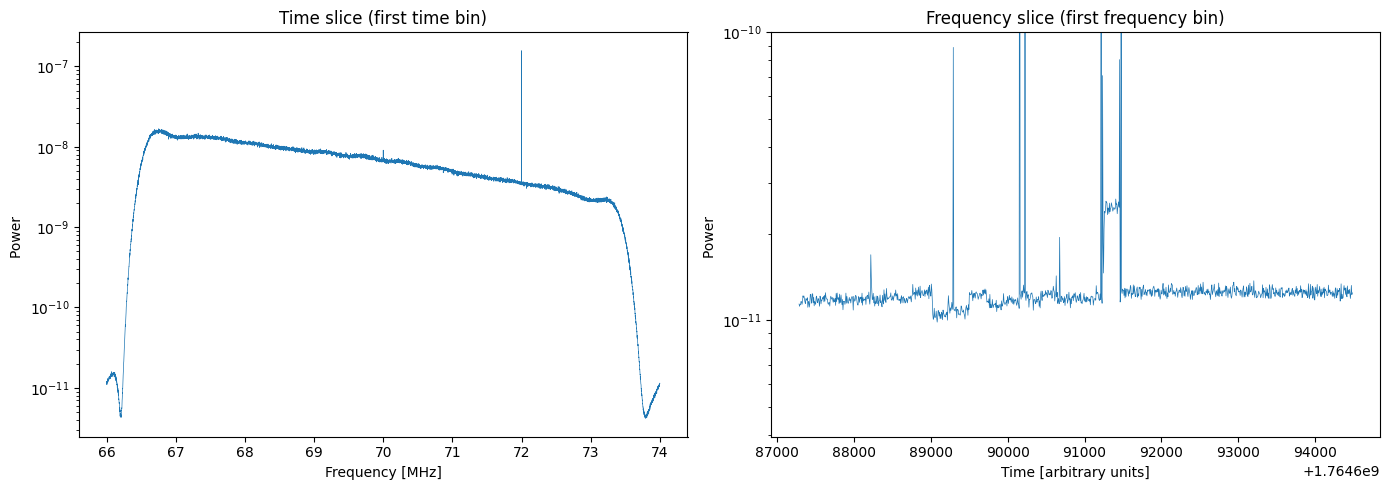

In [3]:
# plot a time slice and a frequency slice to visualize the data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(freqs, waterfall[0, :], linewidth=0.5)
axes[0].set_xlabel('Frequency [MHz]')
axes[0].set_ylabel('Power ')
axes[0].set_title('Time slice (first time bin)')
axes[0].set_yscale('log')
axes[1].plot(times, waterfall[:, -1], linewidth=0.5)
axes[1].set_xlabel('Time [arbitrary units]')
axes[1].set_ylabel('Power ')
axes[1].set_title('Frequency slice (first frequency bin)')
axes[1].set_yscale('log')
axes[1].set_ylim(waterfall.min(), 1e-10)
plt.tight_layout()
plt.show()

## 2. Visualize Raw Waterfall

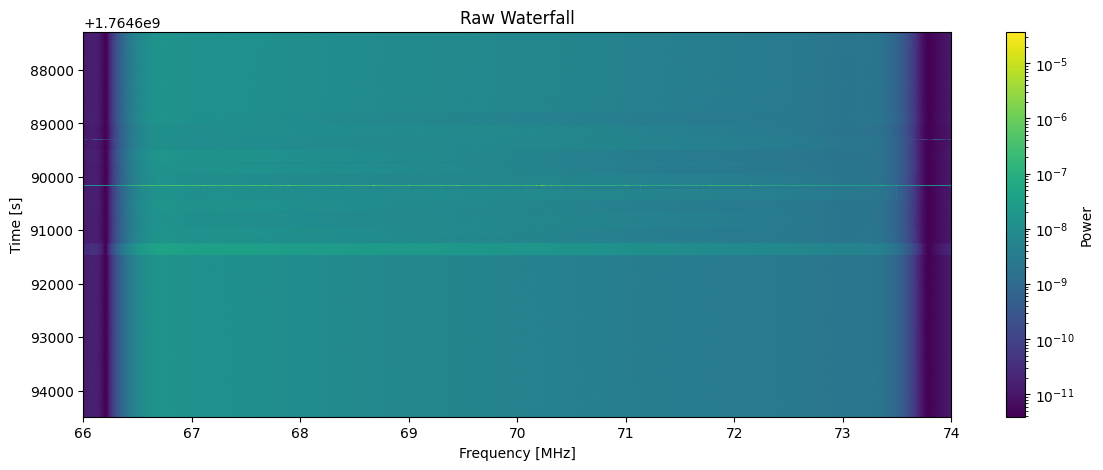

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
plot_waterfall(waterfall, freqs, times, ax=ax, title="Raw Waterfall")
plt.show()

## 3. Run Default Fitter (Phase 1 + Phase 2)

In [7]:
fitter = IterativeSurfaceFitter(
    sigma_threshold=3.0,
    phase1_degree=5,
    phase2_degree_freq=10,
    phase2_degree_time=5,
    max_iterations=20,
    one_sided_clipping=False
)

mask = fitter.fit(waterfall)

Phase 1: Sigma Calibration (isotropic degree 5)
  Noise estimator: mad
  Number of basis terms: 21
  Iter  1: sigma=0.282567, flagged=215907 (2.3221%), changed=215907 (2.322100%)
  Iter  2: sigma=0.258484, flagged=345398 (3.7148%), changed=132043 (1.420135%)
  Iter  3: sigma=0.239096, flagged=490282 (5.2730%), changed=145820 (1.568308%)
  Iter  4: sigma=0.206802, flagged=659203 (7.0898%), changed=170403 (1.832700%)
  Iter  5: sigma=0.143586, flagged=978471 (10.5235%), changed=324880 (3.494115%)
  Iter  6: sigma=0.105579, flagged=1360050 (14.6275%), changed=386787 (4.159930%)
  Iter  7: sigma=0.059176, flagged=1709009 (18.3806%), changed=354365 (3.811229%)
  Iter  8: sigma=0.039965, flagged=1959018 (21.0694%), changed=299513 (3.221290%)
  Iter  9: sigma=0.032902, flagged=2144906 (23.0687%), changed=303894 (3.268408%)
  Iter 10: sigma=0.028664, flagged=2278237 (24.5027%), changed=295843 (3.181819%)
  Iter 11: sigma=0.026168, flagged=2335208 (25.1154%), changed=240941 (2.591343%)
  Iter 1

## 4. Summary: Original, Surface, Cleaned, Residuals, Mask

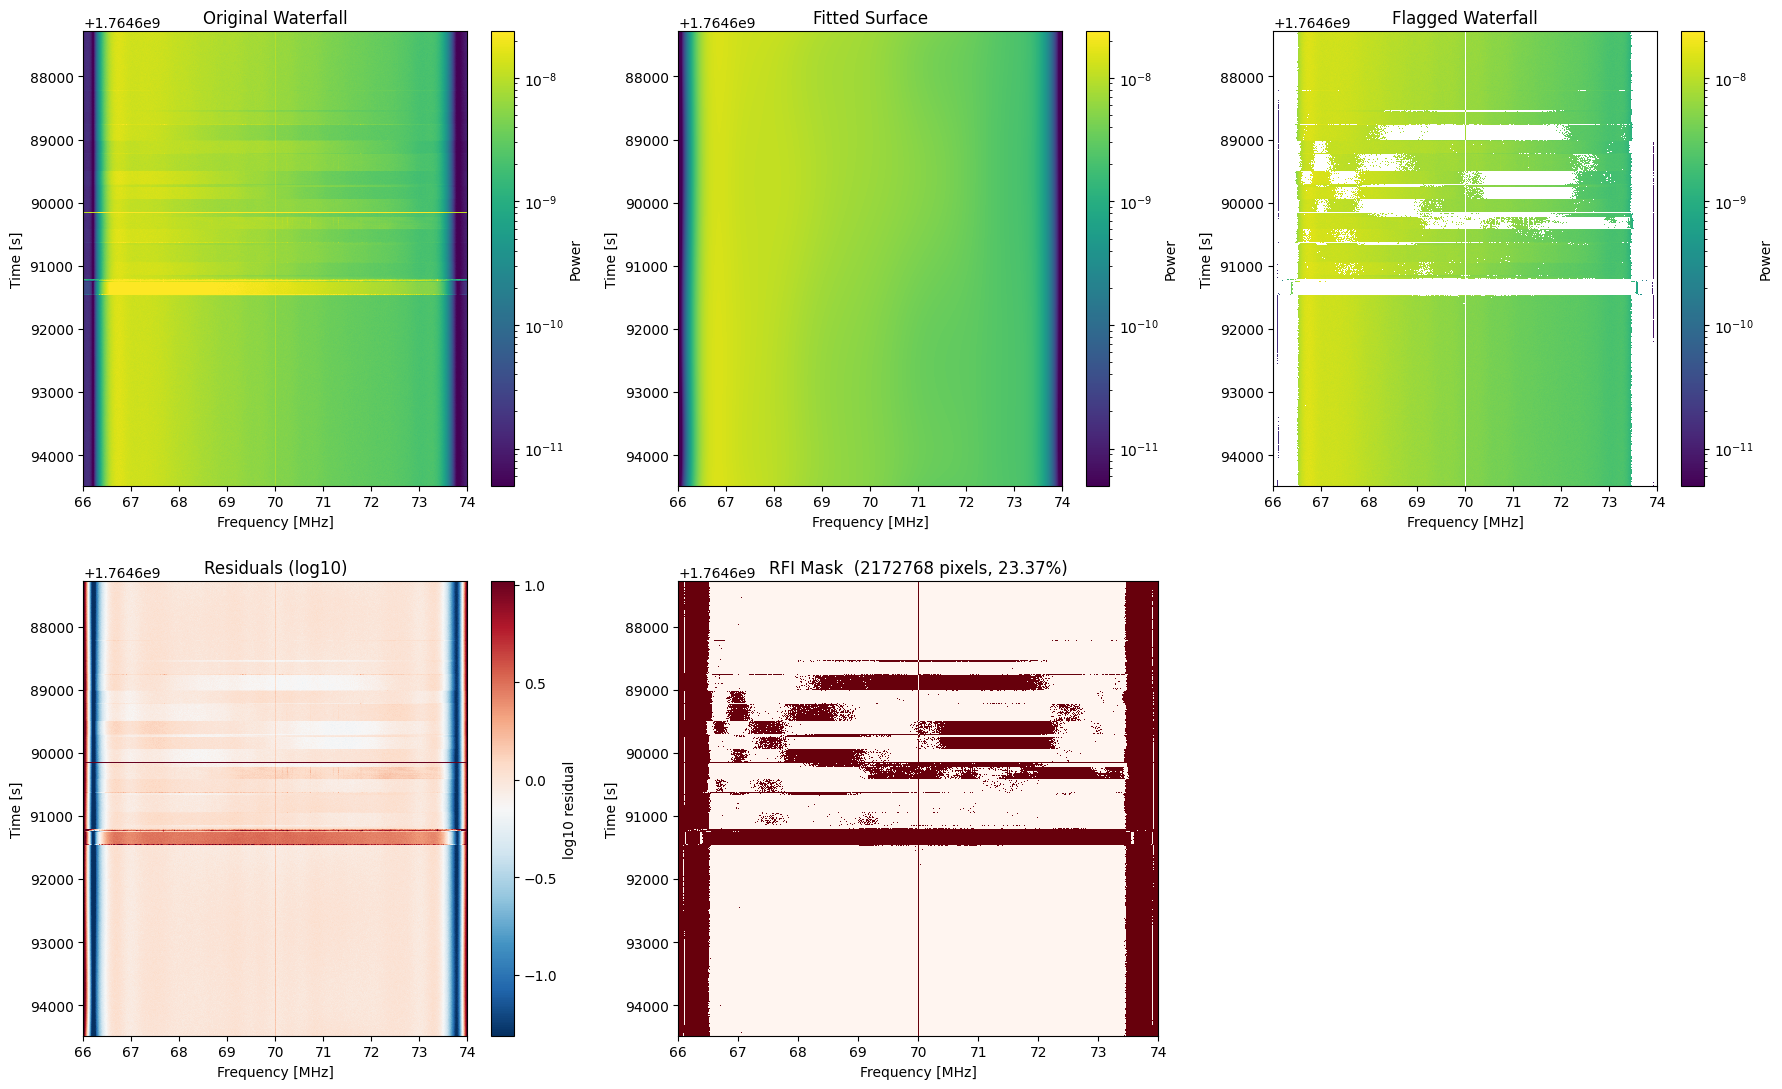

In [8]:
fig = plot_summary(waterfall, fitter, freqs, times)
plt.show()

In [6]:
from MomentRFI.plotting import plot_time_averaged_spectrum

### 1. Time-averaged Spectrum (Before flagging)

<Axes: title={'center': 'Time-Averaged Spectrum'}, xlabel='Frequency [MHz]', ylabel='Power'>

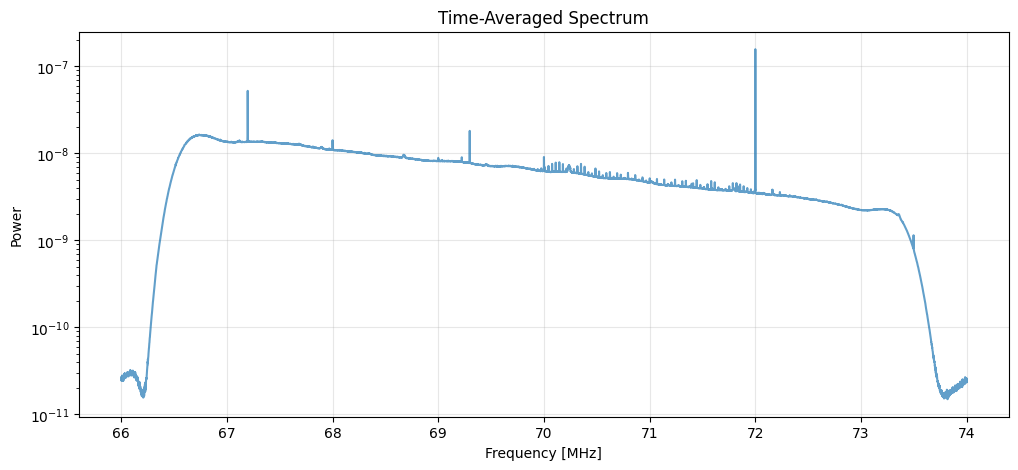

In [7]:
plot_time_averaged_spectrum(waterfall, freqs)

### 2. Time-averaged Spectrum (After flagging)

/Users/zzhang/projects/RFI_flagger/notebooks/../MomentRFI/plotting.py:194: RuntimeWarning: Mean of empty slice
  spectrum_cleaned = np.nanmean(waterfall_cleaned, axis=0)


<Axes: title={'center': 'Time-Averaged Spectrum'}, xlabel='Frequency [MHz]', ylabel='Power'>

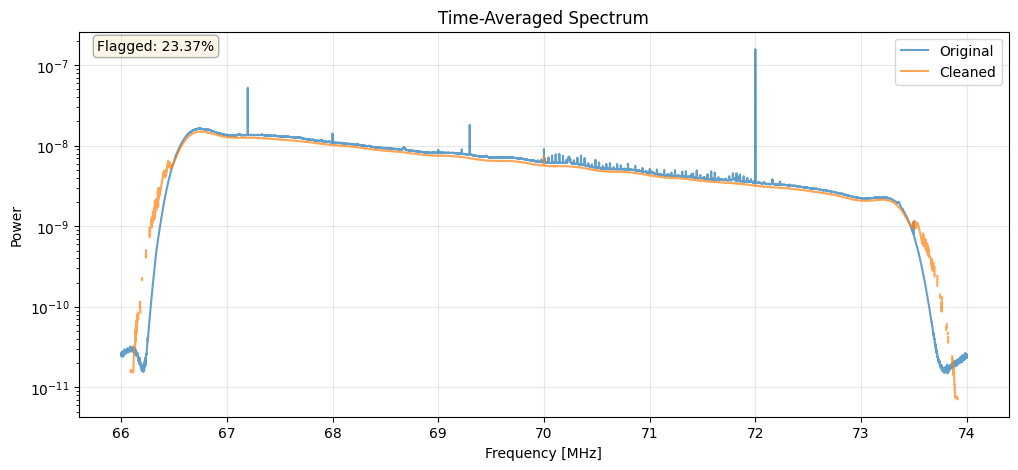

In [8]:
plot_time_averaged_spectrum(waterfall, freqs, mask=fitter.mask)

### 3. A more aggressive flagger

In [14]:
fitter2half = IterativeSurfaceFitter(
    sigma_threshold=2.5,
    phase1_degree=5,
    phase2_degree_freq=10,
    phase2_degree_time=5,
    max_iterations=20
)

mask2half = fitter2half.fit(waterfall)

Phase 1: Sigma Calibration (isotropic degree 5)
  Noise estimator: mad
  Number of basis terms: 21
  Iter  1: sigma=0.282567, flagged=505834 (5.4403%), changed=505834 (5.440292%)
  Iter  2: sigma=0.231389, flagged=915881 (9.8504%), changed=410227 (4.412030%)
  Iter  3: sigma=0.194574, flagged=1288374 (13.8566%), changed=372899 (4.010564%)
  Iter  4: sigma=0.151773, flagged=1653768 (17.7864%), changed=375020 (4.033375%)
  Iter  5: sigma=0.094687, flagged=2030566 (21.8389%), changed=452918 (4.871175%)
  Iter  6: sigma=0.065174, flagged=2187210 (23.5236%), changed=323030 (3.474218%)
  Iter  7: sigma=0.049900, flagged=2295435 (24.6876%), changed=408523 (4.393703%)
  Iter  8: sigma=0.040867, flagged=2471244 (26.5785%), changed=312033 (3.355944%)
  Iter  9: sigma=0.035597, flagged=2607754 (28.0466%), changed=254730 (2.739645%)
  Iter 10: sigma=0.032065, flagged=2688331 (28.9133%), changed=210727 (2.266389%)
  Iter 11: sigma=0.029493, flagged=2725856 (29.3168%), changed=171735 (1.847026%)
  I

/Users/zzhang/projects/RFI_flagger/notebooks/../MomentRFI/plotting.py:194: RuntimeWarning: Mean of empty slice
  spectrum_cleaned = np.nanmean(waterfall_cleaned, axis=0)


<Axes: title={'center': 'Time-Averaged Spectrum'}, xlabel='Frequency [MHz]', ylabel='Power'>

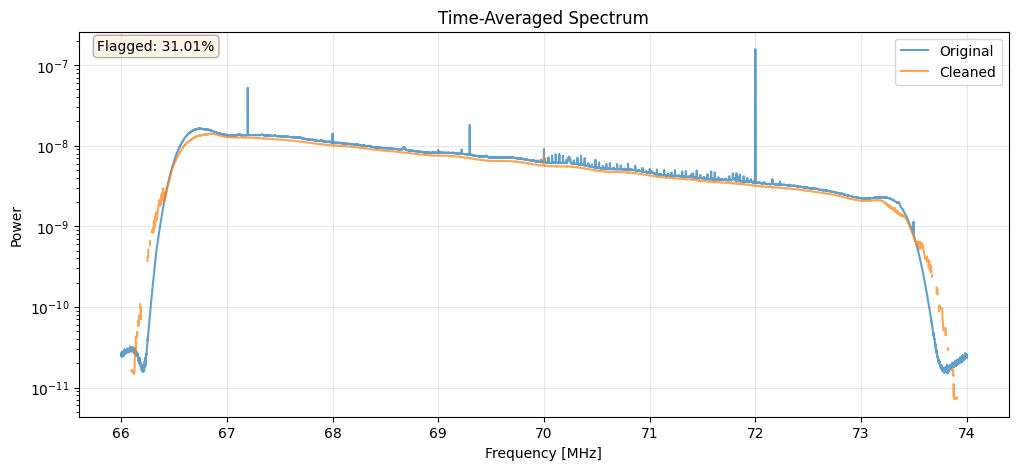

In [15]:
plot_time_averaged_spectrum(waterfall, freqs, mask=fitter2half.mask)